**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Read Car and Notcar images and get a summary

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
%matplotlib inline

In [2]:
cars = []
notcars = []
car_file_list = ['GTI_Far', 'GTI_Left', 'GTI_MiddleClose', 'GTI_Right', 'KITTI_extracted']
notcar_file_list = ['Extras', 'GTI']

for car_file in car_file_list:
    file_path = 'vehicles/' + car_file + '/*.png'
    cars = cars + glob.glob(file_path)
    
for notcar_file in notcar_file_list:
    file_path = 'non-vehicles/' + notcar_file + '/*.png'
    notcars = notcars + glob.glob(file_path)

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: uint8


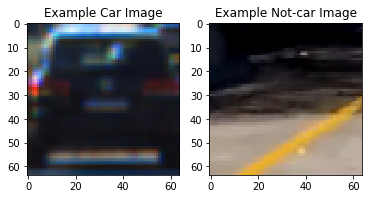

In [3]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    test_image = cv2.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = test_image.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = test_image.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

## get  HOG and other features

In [4]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
# def bin_spatial(img, size=(32, 32)):
#     # Use cv2.resize().ravel() to create the feature vector
#     features = cv2.resize(img, size).ravel() 
#     # Return the feature vector
#     return features

# def color_hist(img, nbins=32, bins_range=(0, 256)):
#     # Compute the histogram of the color channels separately
#     channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
#     channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
#     channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
#     # Concatenate the histograms into a single feature vector
#     hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
#     # Return the individual histograms, bin_centers and feature vector
#     return hist_features

In [5]:
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [6]:
import time

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t = time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

66.27 Seconds to extract HOG features...


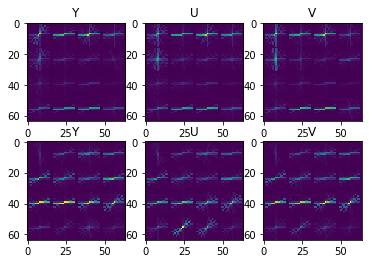

In [55]:
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
fig = plt.figure()
car_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2YUV)
notcar_image = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2YUV)

plt.subplot(231)
plt.imshow(get_hog_features(car_image[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)[1])
plt.title('Y')
plt.subplot(234)
plt.imshow(get_hog_features(notcar_image[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)[1])
plt.title('Y')
plt.subplot(232)
plt.imshow(get_hog_features(car_image[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)[1])
plt.title('U')
plt.subplot(235)
plt.imshow(get_hog_features(notcar_image[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)[1])
plt.title('U')
plt.subplot(233)
plt.imshow(get_hog_features(car_image[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)[1])
plt.title('V')
plt.subplot(236)
plt.imshow(get_hog_features(notcar_image[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)[1])
plt.title('V')

## train a linear SVC

In [7]:
from sklearn.cross_validation import train_test_split

X = np.vstack((car_features, notcar_features)).astype(np.float64)                         
# Fit a per-column scaler
#X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
#scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

/Users/pro/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


In [8]:
#car_features[0].shape

In [9]:
# from sklearn.model_selection import GridSearchCV
# parameters = {'C':[0.1, 0.3, 0.4, 0.5]}
# svc = LinearSVC()
# clf = GridSearchCV(svc, parameters)
# clf.fit(X_train, y_train)

In [10]:
# clf.best_params_

In [11]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

1.3 Seconds to train SVC...
Test Accuracy of SVC =  0.9789
My SVC predicts:  [ 0.  0.  1.  1.  1.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  1.  1.  1.  0.  0.]
0.00224 Seconds to predict 10 labels with SVC


## Sliding windows to find cars

In [12]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, orient, 
              pix_per_cell, cell_per_block, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    bboxes = []
    
    img = img.astype(np.float32)/255
    
    img = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        img = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = img.shape
        img = cv2.resize(img, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = img[:,:,0]
        ch2 = img[:,:,1]
        ch3 = img[:,:,2]
    else: 
        ch1 = img[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
            
    return bboxes
    
print('...')

...


In [14]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 650
scale = 1.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block)

print(len(rectangles), 'rectangles found in image')

6 rectangles found in image


/Users/pro/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/pro/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/pro/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or 

In [15]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

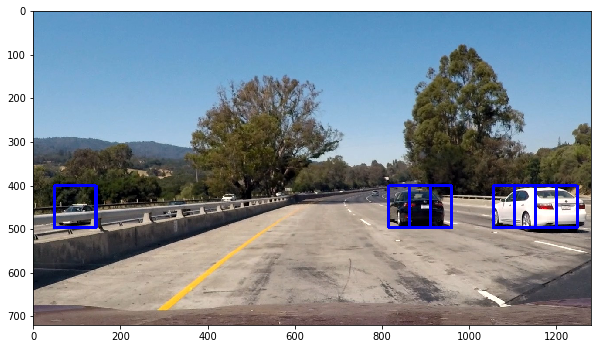

In [16]:
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

## mutiple scale windows

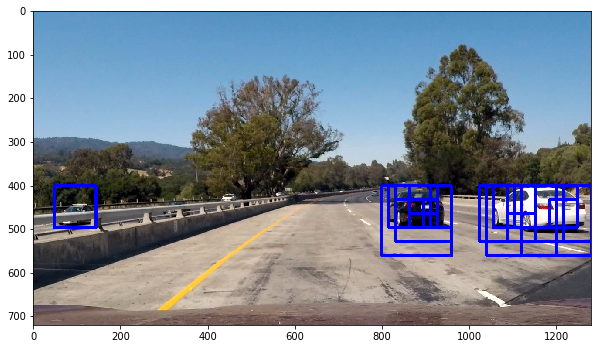

In [17]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
bboxes = []
bboxes.extend(find_cars(test_img, ystart, ystop, 1.0, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))
bboxes.extend(find_cars(test_img, ystart, ystop, 1.5, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))
bboxes.extend(find_cars(test_img, ystart, ystop, 2.0, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))
bboxes.extend(find_cars(test_img, ystart, ystop, 2.5, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))
test_img_rects = draw_boxes(test_img, bboxes)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

In [18]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap
    
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        #print(labels)
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        print(nonzero)
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

(array([400, 400, 400, ..., 495, 495, 495]), array([832, 833, 834, ..., 957, 958, 959]))
(array([400, 400, 400, ..., 527, 527, 527]), array([1056, 1057, 1058, ..., 1213, 1214, 1215]))


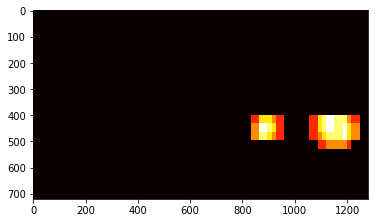

In [19]:
from scipy.ndimage.measurements import label

test_image = test_img
heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,bboxes)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)
plt.imshow(heatmap, cmap='hot')

2 cars found


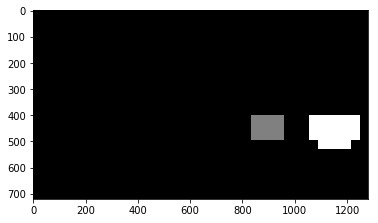

In [20]:
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

In [21]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

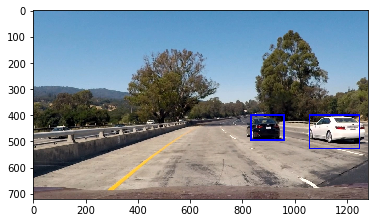

In [22]:
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)
# Display the image
plt.imshow(draw_img)

## Build a pipeline

In [63]:
def process_image(image):
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    ystart = 400
    ystop = 650
    
    bboxes = []
    bboxes.extend(find_cars(image, ystart, ystop, 1.0, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))
    bboxes.extend(find_cars(image, ystart, ystop, 1.5, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))
    bboxes.extend(find_cars(image, ystart, ystop, 2.0, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))
    bboxes.extend(find_cars(image, ystart, ystop, 2.5, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))
    #draw_image = draw_boxes(image, bboxes)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,bboxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    plt.imshow(heatmap)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_image = draw_labeled_bboxes(np.copy(image), labels)
    #draw_image = draw_boxes(np.copy(image), bboxes)
    return draw_image, heatmap

([], <a list of 0 Text yticklabel objects>)

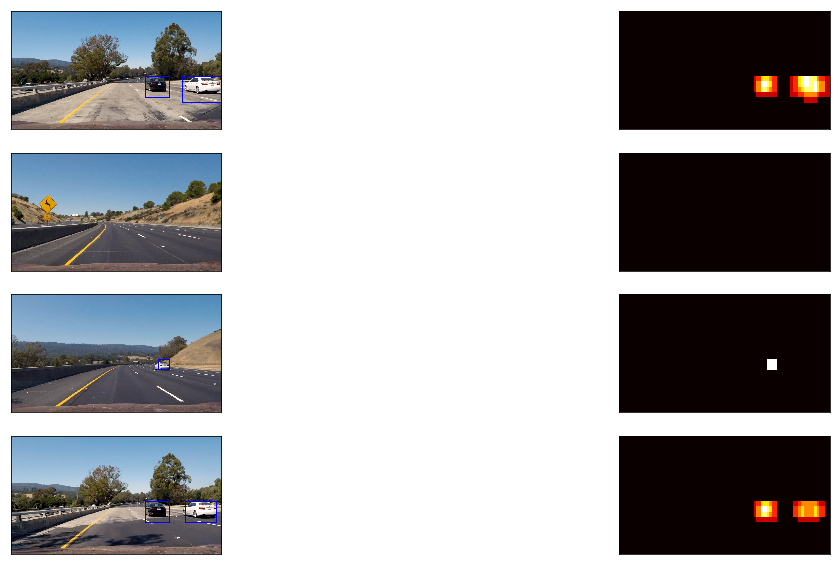

In [66]:
test_image = mpimg.imread('./test_images/test1.jpg')
#temp = process_image(test_image, ystart, ystop, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block)
#plt.imshow(process_image(test_image, ystart, ystop, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))
plt.figure(figsize=(20,10))
plt.subplot(421)
draw_image, heat_map = process_image(test_image)
plt.imshow(draw_image)
plt.xticks([])
plt.yticks([])
plt.subplot(422)
plt.imshow(heat_map, cmap='hot')
plt.xticks([])
plt.yticks([])

test_image = mpimg.imread('./test_images/test2.jpg')
plt.subplot(423)
draw_image, heat_map = process_image(test_image)
plt.imshow(draw_image)
plt.xticks([])
plt.yticks([])
plt.subplot(424)
plt.imshow(heat_map, cmap='hot')
plt.xticks([])
plt.yticks([])

test_image = mpimg.imread('./test_images/test3.jpg')
plt.subplot(425)
draw_image, heat_map = process_image(test_image)
plt.imshow(draw_image)
plt.xticks([])
plt.yticks([])
plt.subplot(426)
plt.imshow(heat_map, cmap='hot')
plt.xticks([])
plt.yticks([])

test_image = mpimg.imread('./test_images/test4.jpg')
plt.subplot(427)
draw_image, heat_map = process_image(test_image)
plt.imshow(draw_image)
plt.xticks([])
plt.yticks([])
plt.subplot(428)
plt.imshow(heat_map, cmap='hot')
plt.xticks([])
plt.yticks([])

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



 99%|█████████▉| 100/101 [00:43<00:00,  2.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 36.6 s, sys: 6.71 s, total: 43.4 s
Wall time: 45.4 s


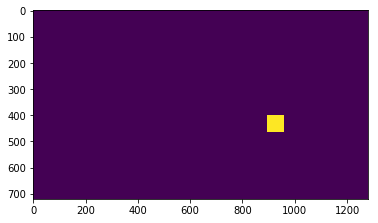

In [32]:
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4').subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

## The boxes are not stable

In [42]:
from collections import deque
def process_image(image):
    #bboxes = []
    bboxes.extend(find_cars(image, ystart, ystop, 1.0, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))
    bboxes.extend(find_cars(image, ystart, ystop, 1.5, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))
    bboxes.extend(find_cars(image, ystart, ystop, 2.0, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))
    bboxes.extend(find_cars(image, ystart, ystop, 2.5, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block))
    
    #delete old boxes until <= 15
    while len(bboxes) > 15:
        bboxes.popleft()
    #draw_image = draw_boxes(image, bboxes)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,bboxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    plt.imshow(heatmap)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_image = draw_labeled_bboxes(np.copy(image), labels)
    return draw_image

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



100%|█████████▉| 1260/1261 [09:48<00:00,  2.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 7min 57s, sys: 1min 26s, total: 9min 23s
Wall time: 9min 49s


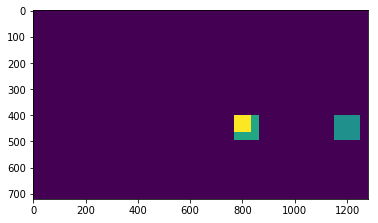

In [43]:
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML
bboxes = deque([])
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(0,5)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)